In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

In [7]:
# Set stock symbol and time period
stock = "GOOG"  # You can change this to any stock symbol
end = datetime.now()
start = datetime(end.year-20, end.month, end.day)

# Download the data
google_data = yf.download(stock, start, end)
print("Data shape:", google_data.shape)
print("\nFirst few rows:")
print(google_data.head())

[*********************100%***********************]  1 of 1 completed

Data shape: (5032, 5)

First few rows:
Price          Close      High       Low      Open     Volume
Ticker          GOOG      GOOG      GOOG      GOOG       GOOG
Date                                                         
2005-01-20  4.812604  4.870429  4.764955  4.777364  361413608
2005-01-21  4.672634  4.848341  4.668663  4.827990  371724110
2005-01-24  4.485014  4.698692  4.475087  4.682809  563010421
2005-01-25  4.395671  4.522737  4.375072  4.515292  427966132
2005-01-26  4.696458  4.700677  4.446050  4.449028  494161321


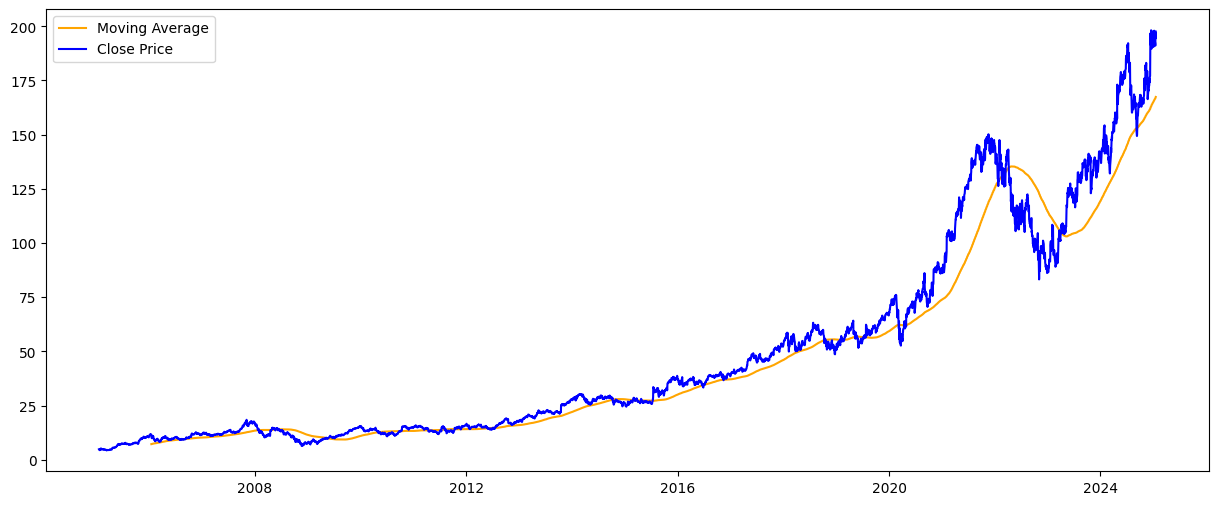

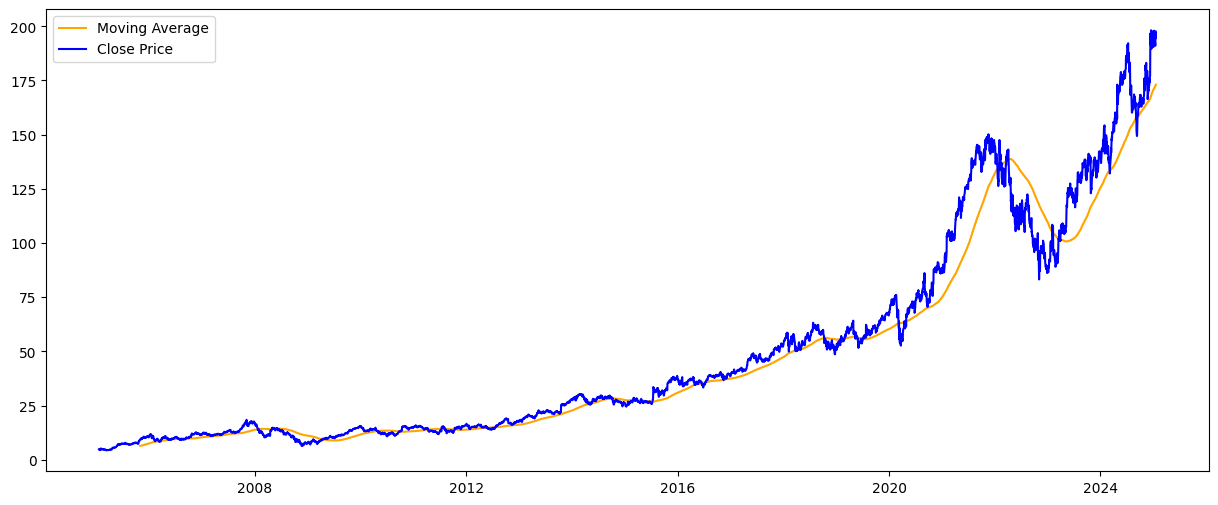

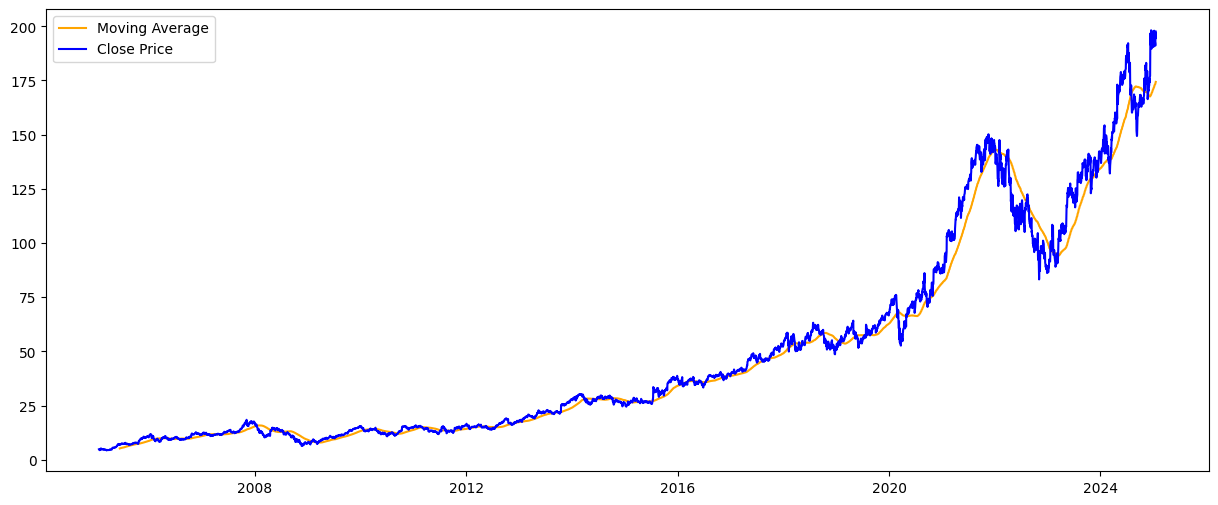

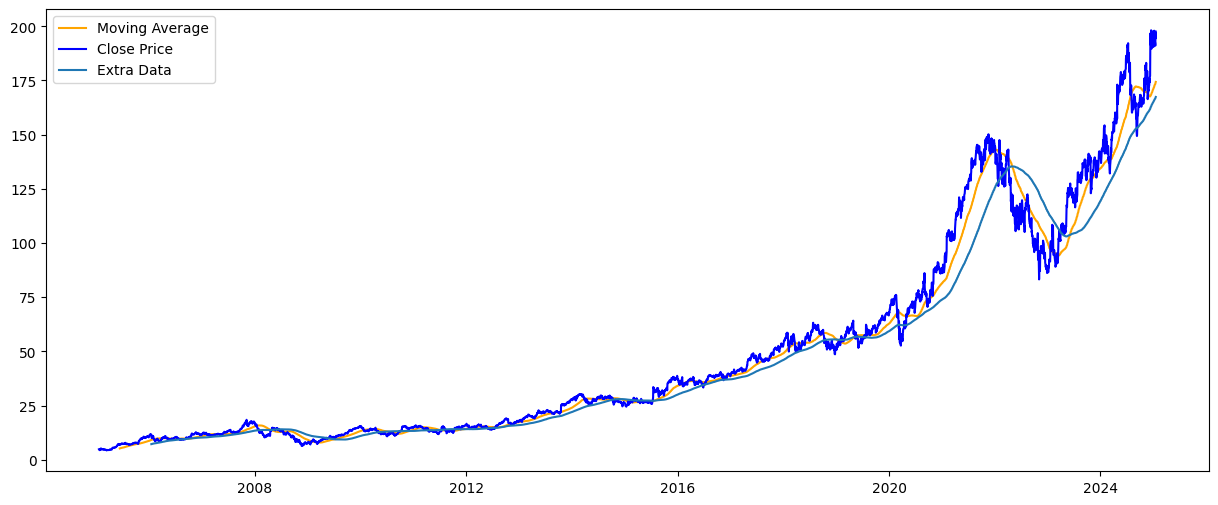

In [8]:
# Calculate different moving averages
google_data['MA_for_250_days'] = google_data.Close.rolling(250).mean()
google_data['MA_for_200_days'] = google_data.Close.rolling(200).mean()
google_data['MA_for_100_days'] = google_data.Close.rolling(100).mean()

# Plotting function
def plot_graph(values, full_data, extra_data=None):
    plt.figure(figsize=(15,6))
    plt.plot(values, 'Orange', label='Moving Average')
    plt.plot(full_data.Close, 'b', label='Close Price')
    if extra_data is not None:
        plt.plot(extra_data, label='Extra Data')
    plt.legend()
    plt.show()

# Plot different moving averages
plot_graph(google_data['MA_for_250_days'], google_data)
plot_graph(google_data['MA_for_200_days'], google_data)
plot_graph(google_data['MA_for_100_days'], google_data)
plot_graph(google_data['MA_for_100_days'], google_data, google_data['MA_for_250_days'])

In [9]:
# Split data
splitting_len = int(len(google_data) * 0.7)

# Create the test dataset - now keeping it as a Series
test_data = google_data['Close'][splitting_len:]

# Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(test_data.values.reshape(-1, 1))

# Create sequences
x_data = []
y_data = []

for i in range(100, len(scaled_data)):
    x_data.append(scaled_data[i-100:i].flatten())
    y_data.append(scaled_data[i])

x_data = np.array(x_data)
y_data = np.array(y_data)

print("X data shape:", x_data.shape)
print("Y data shape:", y_data.shape)

X data shape: (1410, 100)
Y data shape: (1410, 1)


In [12]:
#Before model
y_data = y_data.ravel()

# Create and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_data, y_data)

# Make predictions
predictions = model.predict(x_data)
predictions = predictions.reshape(-1, 1)

# Inverse transform predictions
inv_pre = scaler.inverse_transform(predictions)
inv_y_test = scaler.inverse_transform(y_data.reshape(-1, 1))

Original values vs Predicted values:
            original_test_data  predictions
Date                                       
2019-06-12           53.658699    53.989042
2019-06-13           54.243599    54.169510
2019-06-14           54.073212    54.241252
2019-06-17           54.429428    54.476355
2019-06-18           54.982445    54.908240


<Figure size 1200x480 with 0 Axes>

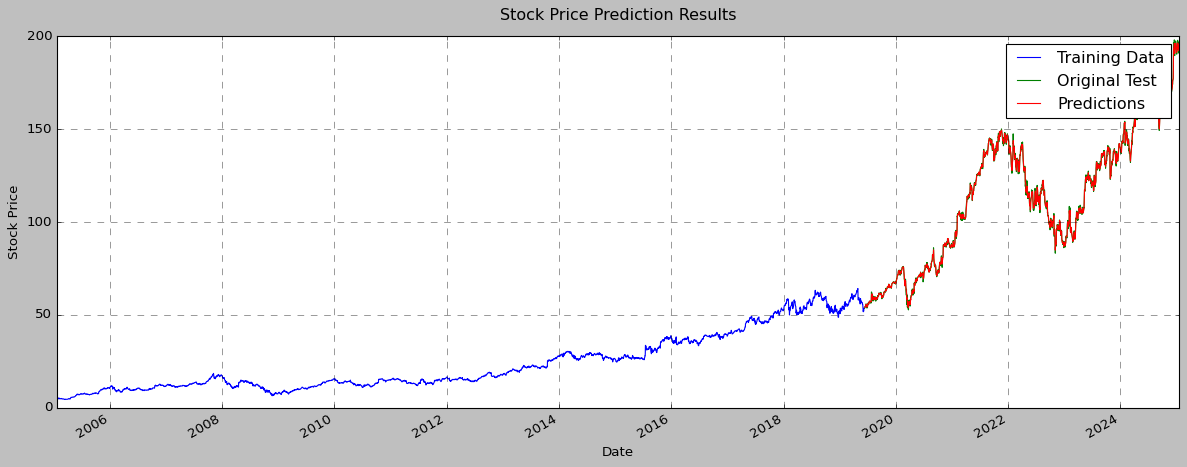

In [15]:
# Create dataframe for plotting
ploting_data = pd.DataFrame(
    {
        'original_test_data': inv_y_test.ravel(),
        'predictions': inv_pre.ravel()
    },
    index=google_data.index[splitting_len+100:]
)

# Display results
print("Original values vs Predicted values:")
print(ploting_data.head())

# Set up matplotlib for Jupyter
%matplotlib inline
plt.style.use('classic')  # Using classic style instead of seaborn

# Create the plot
plt.figure(figsize=(15,6))
whole_data = pd.concat([
    pd.Series(google_data.Close[:splitting_len+100].values.ravel(), 
             index=google_data.index[:splitting_len+100],
             name='Training Data'),
    pd.Series(ploting_data['original_test_data'],
             name='Original Test'),
    pd.Series(ploting_data['predictions'],
             name='Predictions')
], axis=1)

# Plot with improved styling
whole_data.plot(figsize=(15,6))
plt.legend(["Training Data", "Original Test", "Predictions"])
plt.title('Stock Price Prediction Results', pad=15)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()